In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)
import umap
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from joblib import dump, load

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

In [5]:
# data import
train_set = "https://raw.githubusercontent.com/Programming-Systems-Lab/Capstone-2/master/data/Training_Data/Training_Dataset.csv"
X = pd.read_csv(train_set)
train_label = "https://raw.githubusercontent.com/Programming-Systems-Lab/Capstone-2/master/data/Training_Data/Labels_trainingset.csv"
train_labels = pd.read_csv(train_label)
pairs = pd.read_csv("/Users/duanyueyun/Desktop/Capstone/notebooks (final)/Download apk/repackaging_pairs.txt")

In [6]:
print("Distribution of target:")
train_labels['label'].value_counts()/train_labels.shape[0]

Distribution of target:


1    0.789893
0    0.210107
Name: label, dtype: float64

In [5]:
X.shape

(9538, 873)

In [7]:
zero_var_cols = X.columns[X.nunique()==1].to_list()
# Drop features with 0 variance
X.drop(zero_var_cols, axis = 1, inplace = True)
print(zero_var_cols)

['Permission: REQUEST_DELETE_PACKAGES', 'Permission: BIND_MIDI_DEVICE_SERVICE', 'Permission: BIND_TV_INPUT', 'Permission: com.android.voicemail.permission.ADD_VOICEMAIL', 'Permission: com.android.launcher.permission.UNINSTALL_SHORTCUT', 'Permission: READ_PHONE_NUMBERS', 'Permission: GET_ACCOUNTS_PRIVILEGED', 'Permission: REQUEST_COMPANION_RUN_IN_BACKGROUND', 'Permission: ANSWER_PHONE_CALLS', 'Permission: BIND_CARRIER_SERVICES', 'Permission: REQUEST_IGNORE_BATTERY_OPTIMIZATIONS', 'Permission: ACCESS_NOTIFICATION_POLICY', 'Permission: com.android.voicemail.permission.READ_VOICEMAIL', 'Permission: BODY_SENSORS', 'Permission: BIND_SCREENING_SERVICE', 'Permission: REQUEST_COMPANION_USE_DATA_IN_BACKGROUND', 'Permission: BIND_TELECOM_CONNECTION_SERVICE', 'Permission: BIND_VOICE_INTERACTION', 'Permission: BIND_CHOOSER_TARGET_SERVICE', 'Permission: com.android.launcher.permission.INSTALL_SHORTCUT', 'Permission: BIND_AUTOFILL_SERVICE', 'Permission: USE_FINGERPRINT', 'Permission: com.android.voic

In [8]:
# drop duplicate rows
X = X[~X.duplicated(keep='first')]
y = train_labels['label']

In [9]:
print(X.shape)
print(y.shape)

(9538, 342)
(9538,)


# Training SVM Model

## Splitting Training and Test set

In [15]:
useless_cols = ['SHA256', 'Package_Name', 'ThumbPrint', 'Application_Category', 
                'Family_Name', 'Malware_Category', 'Malware/Benign',
                'sdkVersion', 'targetSdkVersion']

In [16]:
sensor_cols = X.loc[:, 'accelerometer':'temperature'].columns.to_list()
print(sensor_cols)

['accelerometer', 'gravity', 'gyroscope', 'light', 'linear_acceleration', 'magnetic_field', 'orientation', 'proximity', 'rotation_vector', 'temperature']


In [17]:
features = X.drop(columns=useless_cols).columns.to_list()
features_wo_sensors = X.drop(columns=useless_cols+sensor_cols).columns.to_list()

In [18]:
print(len(features))
print(len(features_wo_sensors))

333
323


In [19]:
X[sensor_cols].sum(axis=0)

accelerometer           606
gravity                 227
gyroscope               227
light                     2
linear_acceleration     227
magnetic_field          367
orientation            1053
proximity                 6
rotation_vector         227
temperature               1
dtype: int64

In [20]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

X_train_wo_sensor, X_test_wo_sensor, y_train_wo_sensor, y_test_wo_sensor = \
train_test_split(X.drop(columns=sensor_cols), y, test_size = 0.2, random_state = 123, stratify = y)

In [21]:
print(X_train[features].shape)
print(X_test[features].shape)

(7630, 333)
(1908, 333)


In [22]:
print(X_train_wo_sensor[features_wo_sensors].shape)
print(X_test_wo_sensor[features_wo_sensors].shape)

(7630, 323)
(1908, 323)


# Training SVM Model

In [18]:
model = SVC(class_weight='balanced')

In [19]:
avg_val_score = np.mean(cross_val_score(model, X_train[features], y_train, cv = 5,
                                       scoring = "balanced_accuracy"))
print('The mean test score of SVM model with sensor features is:', avg_val_score)

The mean test score of SVM model with sensor features is: 0.902225683855319


In [20]:
avg_val_score = np.mean(cross_val_score(model, X_train_wo_sensor[features_wo_sensors], 
                                        y_train_wo_sensor, cv = 5,
                                       scoring = "balanced_accuracy"))
print('The mean test score of SVM model without sensor features is:', avg_val_score)

The mean test score of SVM model without sensor features is: 0.8998857091930119


## Tuning Hyperparameters

**1. Training on Dataset Including Sensor Features**

In [21]:
# Tune C of Logistic Regression
pipe_with_sensor = make_pipeline(SVC(class_weight='balanced'))

params = {'svc__kernel': ['poly', 'rbf'],
          'svc__C': [0.2, 0.5, 1, 10, 100]}

grid_with_sensor = GridSearchCV(pipe_with_sensor, param_grid = params,
                               scoring = "balanced_accuracy")
grid_with_sensor.fit(X_train[features], y_train)

GridSearchCV(estimator=Pipeline(steps=[('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.2, 0.5, 1, 10, 100],
                         'svc__kernel': ['poly', 'rbf']},
             scoring='balanced_accuracy')

In [22]:
result_with_sensor = pd.DataFrame(grid_with_sensor.cv_results_)

In [73]:
result_with_sensor = pd.read_csv("result_with_sensor.csv")

Text(0.5, 1.0, 'Mean Test Score of SVM with Different C (Including Sensor Features)')

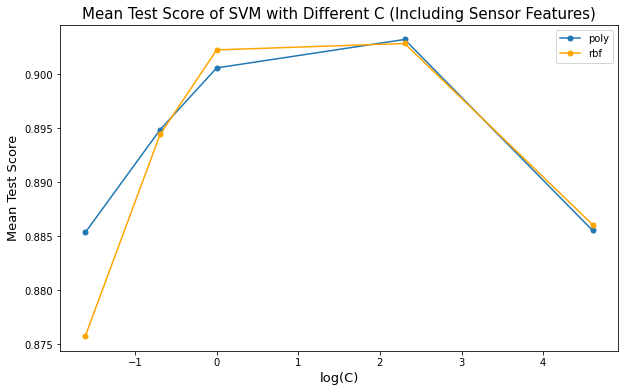

In [23]:
poly_scores = result_with_sensor[result_with_sensor['param_svc__kernel']=='poly']['mean_test_score']
rbf_scores = result_with_sensor[result_with_sensor['param_svc__kernel']=='rbf']['mean_test_score']
plt.figure(figsize = (10, 6))
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), poly_scores, marker = 'o', markersize = 5,
        label='poly')
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), rbf_scores, marker = 'o', markersize = 5, c='orange',
        label='rbf')
plt.legend()
plt.xlabel('log(C)', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of SVM with Different C (Including Sensor Features)', fontsize = 15)

In [24]:
result_with_sensor.to_csv("result_with_sensor_1130.csv",index=False)
dump(grid_with_sensor, 'grid_with_sensor_1130.joblib') 

['grid_with_sensor_1130.joblib']

**2. Training on Dataset Not Including Sensor Features**

In [25]:
pipe_wo_sensor = make_pipeline(SVC(class_weight='balanced'))

params = {'svc__kernel': ['poly', 'rbf'],
          'svc__C': [0.2, 0.5, 1, 10, 100]}

grid_wo_sensor = GridSearchCV(pipe_wo_sensor, param_grid = params)
grid_wo_sensor.fit(X_train_wo_sensor[features_wo_sensors], y_train_wo_sensor)

GridSearchCV(estimator=Pipeline(steps=[('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.2, 0.5, 1, 10, 100],
                         'svc__kernel': ['poly', 'rbf']})

In [26]:
result_wo_sensor = pd.DataFrame(grid_wo_sensor.cv_results_)

In [76]:
result_wo_sensor = pd.read_csv("result_wo_sensor.csv")

Text(0.5, 1.0, 'Mean Test Score of SVM with Different C (Without Sensor Features)')

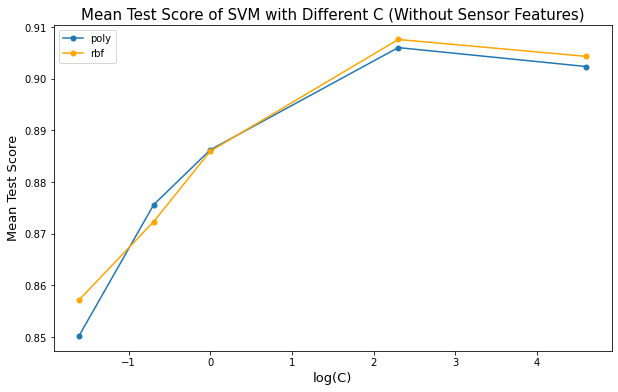

In [27]:
poly_scores2 = result_wo_sensor[result_wo_sensor['param_svc__kernel']=='poly']['mean_test_score']
rbf_scores2 = result_wo_sensor[result_wo_sensor['param_svc__kernel']=='rbf']['mean_test_score']
plt.figure(figsize = (10, 6))
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), poly_scores2, marker = 'o', markersize = 5,
        label='poly')
plt.plot(np.log([0.2, 0.5, 1, 10, 100]), rbf_scores2, marker = 'o', markersize = 5, c='orange',
        label='rbf')
plt.legend()
plt.xlabel('log(C)', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of SVM with Different C (Without Sensor Features)', fontsize = 15)

In [28]:
# export models
result_wo_sensor.to_csv("result_wo_sensor_1130.csv",index=False)
dump(grid_wo_sensor, 'grid_wo_sensor_1130.joblib') 

['grid_wo_sensor_1130.joblib']

## Evaluation on Test Data

Adding sensor features improves balanced accuracy slightly.

In [23]:
# Load models
grid_with_sensor = load('grid_with_sensor_1130.joblib') 
grid_wo_sensor = load('grid_wo_sensor_1130.joblib') 

In [24]:
# make prediction
y_pred_with_sensor = grid_with_sensor.predict(X_test[features])
y_pred_wo_sensor = grid_wo_sensor.predict(X_test_wo_sensor[features_wo_sensors])

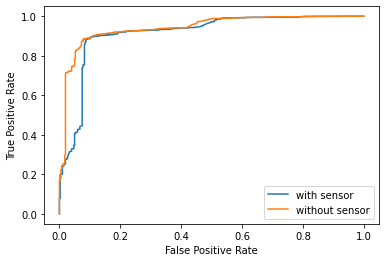

In [25]:
from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(1, 1)
plot_roc_curve(grid_with_sensor, X_test[features], y_test, label='with sensor',
              ax=ax) 
plot_roc_curve(grid_wo_sensor, X_test_wo_sensor[features_wo_sensors], y_test_wo_sensor, label='without sensor',
              ax=ax)
plt.legend()

### Balanced accuracy

In [50]:
print("Test score with sensors:",  round(balanced_accuracy_score(y_test, y_pred_with_sensor),3))
print("Test score without sensors:", round(balanced_accuracy_score(y_test_wo_sensor, y_pred_wo_sensor),3))

Test score with sensors: 0.866
Test score without sensors: 0.879


### AUC, precision and recall

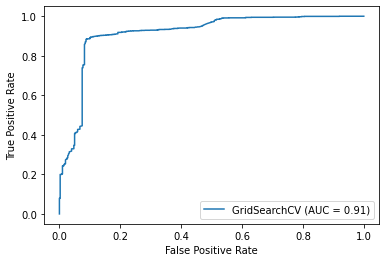

In [52]:
plot_roc_curve(grid_with_sensor, X_test[features], y_test) 

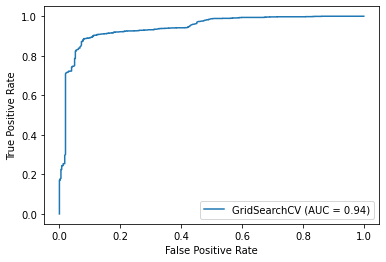

In [54]:
plot_roc_curve(grid_wo_sensor, X_test_wo_sensor[features_wo_sensors], y_test_wo_sensor) 

In [56]:
print("Precision with sensors:")
print(np.round(precision_score(y_test, y_pred_with_sensor, average=None),3))
print("Precision without sensors:")
print(np.round(precision_score(y_test, y_pred_wo_sensor, average=None),3))
print("Recall with sensors:")
print(np.round(recall_score(y_test, y_pred_with_sensor, average=None),3))
print("Recall without sensors:")
print(np.round(recall_score(y_test, y_pred_wo_sensor, average=None),3))

Precision with sensors:
[0.705 0.951]
Precision without sensors:
[0.718 0.957]
Recall with sensors:
[0.823 0.908]
Recall without sensors:
[0.845 0.912]


In [26]:
confusion_matrix(y_test, y_pred_with_sensor)

array([[ 330,   71],
       [ 138, 1369]])

In [27]:
confusion_matrix(y_test, y_pred_wo_sensor)

array([[ 339,   62],
       [ 133, 1374]])

### ThumbPrint score

In [57]:
data = pd.read_csv(train_set)

In [28]:
#X_test = X_test.merge(data[['SHA256', 'ThumbPrint']], 
#                      left_index=True, right_index=True)
X_test['y_pred_with_sensor'] = y_pred_with_sensor
X_test['y_pred_wo_sensor'] = y_pred_wo_sensor
X_test['label'] = y_test

In [29]:
# scores of top 10 authors
X_test['correct'] = X_test['label'] == X_test['y_pred_with_sensor']
summ = X_test[X_test['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct']/summ['N']
summ

,N,correct,score
ThumbPrint,,,
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,111,77.0,0.693694
F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71.0,1.000000
95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,55,55.0,1.000000
28EAC321D548B4247D9C84810C0656EC9426716B,54,34.0,0.629630
45A195BE1E17B3AFA086623DCC4661DEE2043B70,51,51.0,1.000000
F243B92AD5EABA98BD43084864C4D5483F191CD9,42,30.0,0.714286
00F7DCC41988D8642C51D4F8BA5A42C413275885,40,40.0,1.000000
6C699C8D1F7157366994ACDA5495051F2C58D7AB,38,38.0,1.000000
5BFC55F389F4B5427341E4320A501711140AE444,36,21.0,0.583333


In [30]:
# scores of top 10 authors
X_test['correct2'] = X_test['label'] == X_test['y_pred_wo_sensor']
summ = X_test[X_test['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct2=('correct2','sum'))\
.sort_values(['N','correct2'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct2']/summ['N']
summ

,N,correct2,score
ThumbPrint,,,
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,111,79.0,0.711712
F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71.0,1.000000
95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,55,55.0,1.000000
28EAC321D548B4247D9C84810C0656EC9426716B,54,34.0,0.629630
45A195BE1E17B3AFA086623DCC4661DEE2043B70,51,51.0,1.000000
F243B92AD5EABA98BD43084864C4D5483F191CD9,42,30.0,0.714286
00F7DCC41988D8642C51D4F8BA5A42C413275885,40,40.0,1.000000
6C699C8D1F7157366994ACDA5495051F2C58D7AB,38,38.0,1.000000
5BFC55F389F4B5427341E4320A501711140AE444,36,21.0,0.583333


### Paired apps v.s. non-paired apps

In [33]:
X_test.shape

(2230, 358)

In [34]:
X_train[['SHA256', 'label']].head()

,SHA256,label
10216,C3749F164B5ED2B057354A4E3BDAF276A25439F054802C...,1
3300,B177607E760F9F0FCE4F871D8305A8D4750F735A7EE284...,1
8293,9310B15BD3EA2ACF651EE7AB1ED64FD15034D9A26F57F1...,1
2329,21E8E620CF551C0E95B47F03059DC76B09E736A44DAFBA...,1
6357,706E75BA4F06BB5EE06FDFD6ECE57635F136AAFA70AD64...,1


In [31]:
# obtain pairs where both the original and repackaged apps are in the benign/malware dataset
sample_pairs = pairs[(pairs['SHA256_ORIGINAL'].isin(X['SHA256']))&
                     (pairs['SHA256_REPACKAGE'].isin(X['SHA256']))]
sample_pairs.shape

(2918, 2)

In [32]:
# apps whose original/repackaged counterpart is in the data
s1 = X_test[(X_test['SHA256'].isin(sample_pairs['SHA256_ORIGINAL']))|
           (X_test['SHA256'].isin(sample_pairs['SHA256_REPACKAGE']))]
s1.shape

(721, 347)

In [33]:
# apps whose original/repackaged counterpart is not in the data:
s2 = X_test[(~X_test['SHA256'].isin(sample_pairs['SHA256_ORIGINAL']))&
           (~X_test['SHA256'].isin(sample_pairs['SHA256_REPACKAGE']))]
s2.shape

(1187, 347)

In [34]:
print("Including sensor features:")
print("Overall accuracy:", X_test['correct'].mean())
print("Accuracy for apps whose original/repackaged counterpart is in the data:",
     s1['correct'].mean())
print("Accuracy for apps whose original/repackaged counterpart is not in the data:",
     s2['correct'].mean())

Including sensor features:
Overall accuracy: 0.890461215932914
Accuracy for apps whose original/repackaged counterpart is in the data: 0.7739251040221914
Accuracy for apps whose original/repackaged counterpart is not in the data: 0.9612468407750632


In [35]:
print("Excluding sensor features:")
print("Overall accuracy:", X_test['correct2'].mean())
print("Accuracy for apps whose original/repackaged counterpart is in the data:",
     s1['correct2'].mean())
print("Accuracy for apps whose original/repackaged counterpart is not in the data:",
     s2['correct2'].mean())

Excluding sensor features:
Overall accuracy: 0.8977987421383647
Accuracy for apps whose original/repackaged counterpart is in the data: 0.7808599167822469
Accuracy for apps whose original/repackaged counterpart is not in the data: 0.9688289806234204


#### Test on repackaged benign dataset

In [36]:
benign_repack = "https://raw.githubusercontent.com/Programming-Systems-Lab/Capstone-2/master/data/Test_Data/Repackaged_Benign_Testset.csv"
benign_repack = pd.read_csv(benign_repack)
benign_repack_y = "https://raw.githubusercontent.com/Programming-Systems-Lab/Capstone-2/master/data/Test_Data/Labels_testset.csv"
benign_repack_y = pd.read_csv(benign_repack_y)
benign_repack['label'] = benign_repack_y['label']

In [37]:
benign_repack['label'].value_counts()

0    2858
Name: label, dtype: int64

In [38]:
# make prediction
y_pred_with_sensor = grid_with_sensor.predict(benign_repack[features])
y_pred_wo_sensor = grid_wo_sensor.predict(benign_repack[features_wo_sensors])

In [39]:
print("Test score with sensors on repackaged benign apps:",  
      round(accuracy_score(benign_repack_y, y_pred_with_sensor),3))
print("Test score without sensors on repackaged benign apps:", 
      round(accuracy_score(benign_repack_y, y_pred_wo_sensor),3))

Test score with sensors on repackaged benign apps: 0.894
Test score without sensors on repackaged benign apps: 0.901


#### Test on covid repackaged malware dataset

In [40]:
covid_test = "https://raw.githubusercontent.com/Programming-Systems-Lab/Capstone-2/master/data/Test_Data/COVID_Testset.csv"
covid_test = pd.read_csv(covid_test)
covid_label = "https://raw.githubusercontent.com/Programming-Systems-Lab/Capstone-2/master/data/Test_Data/Labels_COVID_testset.csv"
covid_label = pd.read_csv(covid_label)
print(covid_test.shape[0])

157


In [41]:
covid_label['label'].value_counts()

0    157
Name: label, dtype: int64

In [42]:
y_pred_covid_w_sensor = grid_with_sensor.predict(covid_test[features])
y_pred_covid_wo_sensor = grid_wo_sensor.predict(covid_test[features_wo_sensors])

In [43]:
print("Accuracy on covid test set (with sensors):", 
      round(accuracy_score(covid_label['label'], y_pred_covid_w_sensor),3))
print("Accuracy on covid test set (without sensors):", 
      round(accuracy_score(covid_label['label'], y_pred_covid_wo_sensor),3))

Accuracy on covid test set (with sensors): 0.885
Accuracy on covid test set (without sensors): 0.93


In [45]:
covid_test['label'] = covid_label
covid_test['y_pred'] = y_pred_covid_wo_sensor 
covid_test['correct'] = covid_test['label']==covid_test['y_pred']

In [47]:
covid_summ = covid_test.groupby('ThumbPrint').agg(acc=('correct', 'mean'),
                                    count=('correct', 'count'))\
.sort_values(by='count', ascending=False)
covid_summ.head(5)

,acc,count
ThumbPrint,,
C4B73247F90289388E78031733BE2F165BC75934,1.0,23
DB65E329974BDB5A745CBB9ACE7532B72EE7B900,1.0,18
7C92A25D4CE53A729BA11D89E70A59BAE74AE40D,1.0,9
722BEB450FEBF6FFD796ED75A789961E45039870,1.0,6
44E5103E3FAEE7FC70A01542328229F19EB4667E,0.6,5


In [49]:
covid_summ.shape

(64, 2)

In [50]:
covid_summ[covid_summ['acc']<1]

,acc,count
ThumbPrint,,
44E5103E3FAEE7FC70A01542328229F19EB4667E,0.6,5
9FBAAEAEE1BDF175AE9F0598F41E3A70E94C0257,0.0,3
B4BC12B9C74BF154FBF033864F3B825F7FBA7239,0.0,1
A0F251BA5D23FAB43F7680B197DC5EDCD833BB2F,0.0,1
7B28702CBEA0E0E033E183DBE564CD82A2792D2B,0.0,1
693C0A10500ECF8D1E2A56C54694B24BAC9A4AAF,0.0,1
239CBEC7E31895BCA59F91FE49F8B613FA2D8510,0.0,1
FDA551773B6530D6D00A6B7230172C29E0318407,0.0,1


In [48]:
confusion_matrix(covid_label, y_pred_covid_wo_sensor)

array([[146,  11],
       [  0,   0]])